In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# TensorFlow imports
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import TensorBoard

from models.losses import Losses
from models.model import GMM_Survival
from utils.eval_utils import (accuracy_metric, calibration, cindex,
                              cindex_metric)
from utils.utils import ProgBar, setup_env, setup_seed

tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras
# VaDeSC model

# Set Seaborn style for a cleaner look
sns.set(style="whitegrid")
setup_env()
print(os.getcwd())

2024-02-12 14:27:20.223096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 14:27:20.320473: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


CWD: /m/home/home9/97/nguyenq10/unix/HUS/cancer-clusters
GPU: /physical_device:GPU:0
/m/home/home9/97/nguyenq10/unix/HUS/cancer-clusters


2024-02-12 14:27:27.637580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-12 14:27:27.683998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-12 14:27:27.684204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dataset

In [2]:
from datasets.radcure import load_radcure
from sklearn.model_selection import train_test_split



cfg0["seed"] = seed = 3
path = "/u/97/nguyenq10/unix/HUS/cancer-clusters/datasets/radcure/clinical_train.csv"
x, y, cfg0 = load_radcure(path)

x_tr, x_val, y_tr, y_val = train_test_split(
    x, y, train_size=cfg0["train_size"], random_state=cfg0["seed"])

x.shape=(1800, 45), y.shape=(1800, 2)


## VaDeSC

{'seed': 3, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 8, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [50, 100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb12_14-27-27_piet'}


2024-02-12 14:27:27.729975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 14:27:27.731194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-12 14:27:27.731376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-12 14:27:27.731456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-02-12 14:27:37.853585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-12 14:27:38.009071: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f414f09fb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 14:27:38.009121: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-12 14:27:38.020304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 14:27:38.601160: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Progress: 100%|██████████| 1000/1000 [00:45<00:00, 22.09it/s, loss=24.0156, val_output_5_cindex_metric=0.

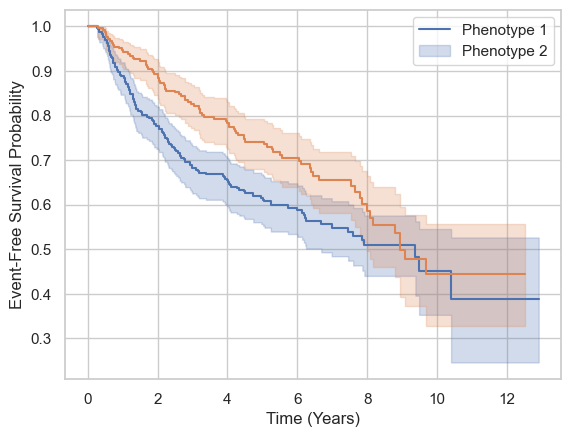

[0.16416846222072806]


In [3]:
from copy import deepcopy
from sklearn.model_selection import ParameterGrid

from main import train
from utils.utils import get_purity

param_grid = {'num_clusters': [2],
              'learning_rate': [1e-3],
              "seed": [seed],
              "layers": [[50, 100]]
              }

# param_grid = {'num_clusters': [2],
#               'learning_rate': [1e-3],
#               "weibull_shape": [2.],
#               "seed": [0],
#               "layers": [[32, 64]],
#               "activation": ["selu"],
#               }

params = ParameterGrid(param_grid)

models = []
for param in params:
    cfg = {k: param[k] if k in param else v for k, v in cfg0.items()}
    print(cfg)
    model, _ = train(x_tr, y_tr, config=cfg, validation_data=(x_val, y_val))
    models.append(model)
    phe_val = model.get_phenotypes(x_val, y_val)
    print(get_purity(y_val, phe_val))

vadesc = models[0]

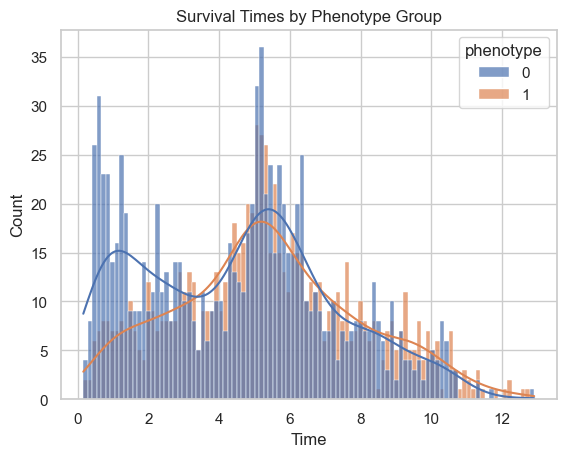

In [4]:
from pandas import DataFrame

phe = model.get_phenotypes(x, y)
sns.histplot(data=DataFrame({'time': y.time, 'phenotype': phe}), x="time", hue="phenotype", kde=True, bins=100, alpha=0.7)

plt.title("Survival Times by Phenotype Group")
plt.xlabel("Time")
plt.ylabel("Count")
plt.show()

## DCM

In [5]:
"DCM"
from auton_survival import reporting
from auton_survival.metrics import phenotype_purity
from auton_survival.models.dcm import DeepCoxMixtures
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid1 = {'k' : [2],
              'learning_rate' : [1e-4],
              'learning_rate' : [1e-3],
              'layers' : [[50,100],[100]]
             }
setup_seed(seed)
params1 = ParameterGrid(param_grid1)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models1 = []
for param in params1:
    print(param)
    model = DeepCoxMixtures(k=param['k'], layers=param['layers'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr.time, y_tr.event, iters = 100, learning_rate=param['learning_rate'])

    phenotypes = np.argmax(model.predict_latent_z(x_val),-1)
    # Estimate the integrated Brier Score at event horizons of 1, 2 and 5 years
    metric_val1 = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                    phenotypes_test=None, outcomes_test=None,
                                    strategy='integrated', horizons=[6], 
                                    bootstrap=None)
    print(metric_val1)
    # Obtain survival probabilities for validation set and compute the integrated Brier Score 
    # predictions_val = model.predict_survival(x_val, times)
    # metric_val2 = survival_regression_metric('ctd', y_val, predictions_val, times, y_tr)
    # metric_val1 = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models1.append([metric_val1, model, param])
    
models1 = sorted(models1, key=lambda x: x[0], reverse=False)
dcm = models1[0][1]
print(models1)

{'k': 2, 'layers': [50, 100], 'learning_rate': 0.001}


 38%|███▊      | 38/100 [00:01<00:02, 25.86it/s]


[0.160187833533432]
{'k': 2, 'layers': [100], 'learning_rate': 0.001}


 41%|████      | 41/100 [00:01<00:02, 28.27it/s]

[0.13583526896965067]
[[[0.13583526896965067], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7f42a47c02e0>, {'k': 2, 'layers': [100], 'learning_rate': 0.001}], [[0.160187833533432], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7f444863f6d0>, {'k': 2, 'layers': [50, 100], 'learning_rate': 0.001}]]


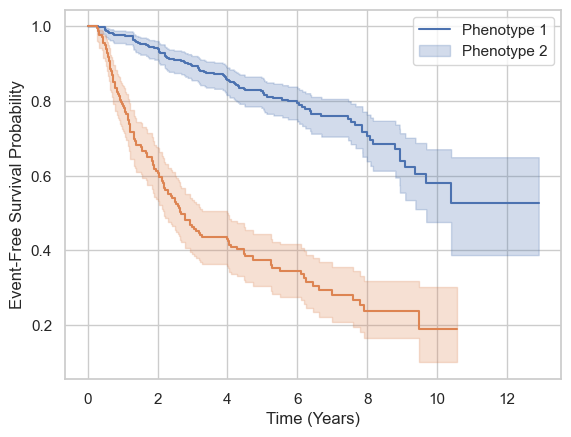

[0.13583526896965067]

In [6]:
from auton_survival import reporting
import matplotlib.pyplot as plt
from auton_survival.models.dcm.dcm_utilities import predict_latent_z

latent_z_prob = model.predict_latent_z(x_val)
phenotypes = np.argmax(latent_z_prob, axis=-1)
# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
reporting.plot_kaplanmeier(y_val, np.array(phenotypes))

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

# Estimate the integrated Brier Score at event horizons of 1, 2 and 5 years
metric = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                phenotypes_test=None, outcomes_test=None,
                                strategy='integrated', horizons=[6], 
                                bootstrap=None)
metric

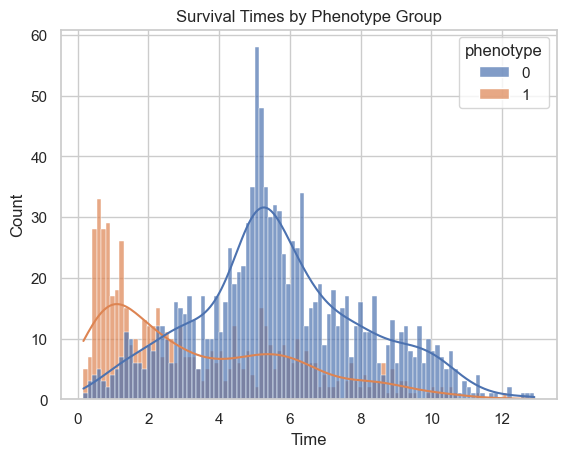

In [7]:
from pandas import DataFrame

latent_z_prob = model.predict_latent_z(x)
phenotypes = np.argmax(latent_z_prob, axis=-1)
# Plot the histogram with a separation by phenotype
sns.histplot(data=DataFrame({'time': y.time, 'phenotype': phenotypes}), x="time", hue="phenotype", kde=True, bins=100, alpha=0.7)

plt.title("Survival Times by Phenotype Group")
plt.xlabel("Time")
plt.ylabel("Count")
plt.show()
# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.

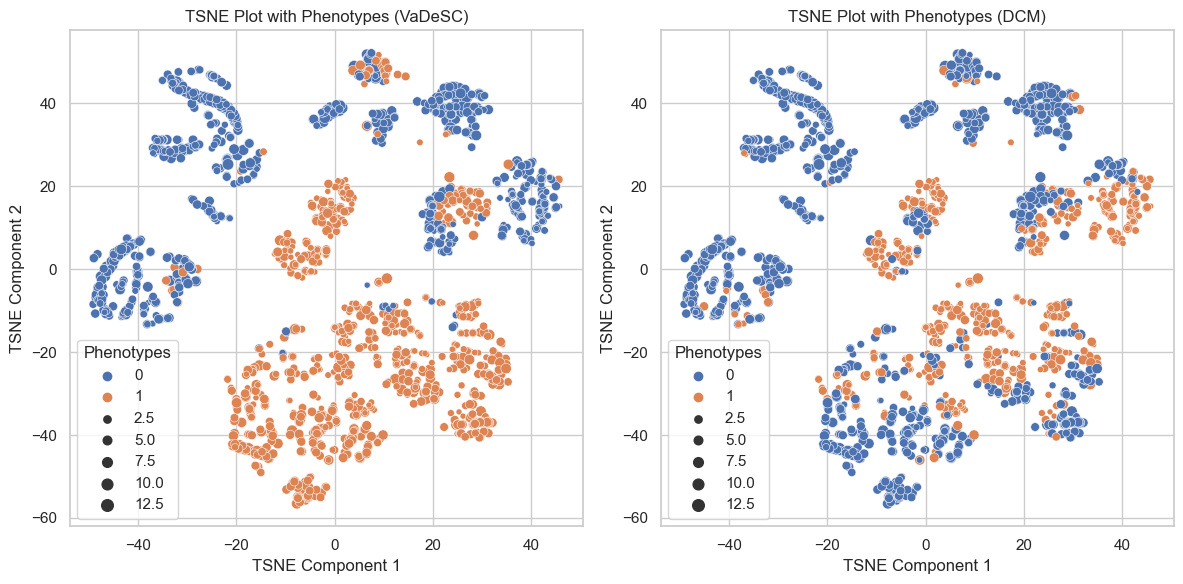

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

phe_vd = vadesc.get_phenotypes(x, y)
phe_vd = np.where(phe_vd == 0, 1, 0)
phe_dcm = np.argmax(dcm.predict_latent_z(x), axis=-1)
tsne = TSNE(n_components=2, random_state=1)
x_tsne = tsne.fit_transform(x)

plt.figure(figsize=(12, 6))

# Plot with hue=phe_vd
plt.subplot(1, 2, 1)
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=phe_vd, size=y.time)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot with Phenotypes (VaDeSC)')
plt.legend(title='Phenotypes', loc='best')

# Plot with hue=phe_dcm
plt.subplot(1, 2, 2)
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=phe_dcm, size=y.time)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot with Phenotypes (DCM)')
plt.legend(title='Phenotypes', loc='best')

plt.tight_layout()
plt.show()


In [9]:
y_tr.values[:1]

array([[1.        , 0.52328767]])

In [10]:
import pandas as pd
import numpy as np
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.util import Surv

# Force conversion of the 'event' column to boolean, handling non-numeric and missing values
def prepare_surv_data(y):
    # Copy to avoid modifying the original DataFrame
    y_cleaned = y.copy()
    
    # Handle missing or ambiguous values explicitly
    # Assuming missing or ambiguous values are marked with NaN or a specific placeholder (e.g., '?')
    # You can adjust this part to handle your specific case of '?' class or missing values
    y_cleaned['event'].replace('?', np.nan, inplace=True)  # Replace '?' with NaN
    y_cleaned.dropna(subset=['event'], inplace=True)  # Drop rows with NaN in 'event'
    
    # Convert to boolean - after cleaning, assuming 1/True/yes for event occurred, 0/False/no for censored
    y_cleaned['event'] = y_cleaned['event'].values.astype(int)  # First, convert to int to handle any stray non-integer representations
    y_cleaned['event'] = y_cleaned['event'].values.astype(bool)  # Then, convert to bool
    
    # Convert to structured array expected by sksurv
    structured_array = np.array(list(zip(y_cleaned['time'], y_cleaned['event'])), dtype=[('time', float), ('event', bool)])
    return structured_array

y_tr_prepared = prepare_surv_data(y_tr)
y_val_prepared = prepare_surv_data(y_val)

# Initialize and train the boosting model for survival analysis
model = ComponentwiseGradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, random_state=0)
model.fit(x_tr, y_tr_prepared)

# Predict median survival times for the validation set
median_surv_times = model.predict_median(x_val)

print("Predicted median survival times:", median_surv_times)


ValueError: elements of event indicator must be boolean, but found float64